# ResNet18 Transfer Learning: Who's that Pokémon?

## Background and Understanding:

## Imports

In [146]:

import torch
import torchvision
import torch.nn as nn 
import torch.optim as optim
import torchvision.models as models
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import pandas as pd
from dataset_class import PokemonImages

In [147]:
import torch.backends.cudnn as cudnn
import numpy as np
import matplotlib.pyplot as plt
import time
import os
from tempfile import TemporaryDirectory

cudnn.benchmark = True

## Data Preperation

In [148]:
df = pd.read_csv('pokemon.csv')
df.head()

,national_number,gen,english_name,japanese_name,primary_type,secondary_type,classification,percent_male,percent_female,height_m,...,evochain_2,evochain_3,evochain_4,evochain_5,evochain_6,gigantamax,mega_evolution,mega_evolution_alt,description,image_path
0,1,I,bulbasaur,Fushigidane,grass,poison,Seed Pokémon,88.14,11.86,0.7,...,Ivysaur,Level,Venusaur,NaN,NaN,NaN,NaN,NaN,There is a plant seed on its back right from t...,pokemon_images/Bulbasaur.jpg
1,2,I,ivysaur,Fushigisou,grass,poison,Seed Pokémon,88.14,11.86,1.0,...,Ivysaur,Level,Venusaur,NaN,NaN,NaN,NaN,NaN,"When the bulb on its back grows large, it appe...",pokemon_images/Ivysaur.jpg
2,3,I,venusaur,Fushigibana,grass,poison,Seed Pokémon,88.14,11.86,2.0,...,Ivysaur,Level,Venusaur,NaN,NaN,Gigantamax Venusaur,Mega Venusaur,NaN,Its plant blooms when it is absorbing solar en...,pokemon_images/Venusaur.jpg
3,4,I,charmander,Hitokage,fire,NaN,Lizard Pokémon,88.14,11.86,0.6,...,Charmeleon,Level,Charizard,NaN,NaN,NaN,NaN,NaN,It has a preference for hot things. When it ra...,pokemon_images/Charmander.jpg
4,5,I,charmeleon,Lizardo,fire,NaN,Flame Pokémon,88.14,11.86,1.1,...,Charmeleon,Level,Charizard,NaN,NaN,NaN,NaN,NaN,"It has a barbaric nature. In battle, it whips ...",pokemon_images/Charmeleon.jpg


### Classifying a Pokémon's Primary type:

In [149]:
df = df.dropna(subset=['image_path', 'primary_type']) 
df['main_type'] = df['primary_type'].str.strip()  

In [150]:
filt = (df["main_type"] == "grass") | (df["main_type"] == "fire") | (df["main_type"] == "water")
df = df[filt]

In [151]:
type_names = df['main_type'].unique().tolist()
print("Classes:", type_names)

Classes: ['grass', 'fire', 'water']


In [152]:
label_encoder = LabelEncoder()
df['encoded_type'] = label_encoder.fit_transform(df['main_type'])
type_encoded = df['encoded_type'].unique().tolist()
print("Classes (Encoded):", type_encoded)

Classes (Encoded): [1, 0, 2]


In [153]:
num_classes = len(type_encoded)
print("Number of Classes: ", num_classes)

Number of Classes:  3


In [154]:
train_df, val_df = train_test_split(df, test_size=0.2, 
                                    stratify=df['encoded_type'], 
                                    random_state = 13)

### Loading Data

In [155]:
transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

In [156]:
train_dataset = PokemonImages(df = train_df, label = "encoded_type", transform=transforms)
val_dataset = PokemonImages(df = val_df, label = "encoded_type", transform=transforms)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

dataloaders = {'train': train_loader, 'val': val_loader}
dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset)}

In [157]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

Using cpu device


## Pre-Trained ResNet18

In [158]:
resnet18 = models.resnet18(weights= models.ResNet18_Weights.DEFAULT)
resnet18

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Freezing the CNN 

In [159]:
# Freezes the whole model
for param in resnet18.parameters():
    param.requires_grad = False

# Reseting the Final Layer and param.requires_grad = True by default 
# Final Layer is resnet18.fc 
final_layer_features = resnet18.fc.in_features

# Outputting new number of Classes
resnet18.fc = nn.Linear(final_layer_features, num_classes)

# Cross Entropy Loss for Multiple Classes
criterion = nn.CrossEntropyLoss()

# Optimizing all Parameters in the final linear layer using SGD
optimizer = optim.SGD(resnet18.fc.parameters(), lr=0.001, momentum=0.9)

# Decrease Learning Rate by a factor of 0.1 every 7 epochs
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

## Training

### Training Function

In [160]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # training mode
                else:
                    model.eval()   # eval mode

                running_loss = 0.0
                running_corrects = 0

                # iterating through data
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients every iteration
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # SGD for backwards
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights based on validation results
        model.load_state_dict(torch.load(best_model_params_path, weights_only=True))
    return model

In [161]:
final_model = train_model(resnet18, criterion, optimizer,
                         lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 1.1343 Acc: 0.3944
val Loss: 1.0602 Acc: 0.4815

Epoch 1/24
----------
train Loss: 1.0217 Acc: 0.4977
val Loss: 0.9298 Acc: 0.6111

Epoch 2/24
----------
train Loss: 0.8310 Acc: 0.6056
val Loss: 0.8434 Acc: 0.5926

Epoch 3/24
----------
train Loss: 0.7220 Acc: 0.7277
val Loss: 0.7202 Acc: 0.7407

Epoch 4/24
----------
train Loss: 0.6426 Acc: 0.7840
val Loss: 0.6732 Acc: 0.7222

Epoch 5/24
----------
train Loss: 0.5546 Acc: 0.7934
val Loss: 0.6191 Acc: 0.7963

Epoch 6/24
----------
train Loss: 0.5512 Acc: 0.8075
val Loss: 0.5779 Acc: 0.7593

Epoch 7/24
----------
train Loss: 0.4844 Acc: 0.8498
val Loss: 0.5765 Acc: 0.7407

Epoch 8/24
----------
train Loss: 0.4722 Acc: 0.8451
val Loss: 0.5735 Acc: 0.7778

Epoch 9/24
----------
train Loss: 0.4778 Acc: 0.8779
val Loss: 0.5784 Acc: 0.7593

Epoch 10/24
----------
train Loss: 0.4819 Acc: 0.8498
val Loss: 0.5799 Acc: 0.7593

Epoch 11/24
----------
train Loss: 0.4687 Acc: 0.8592
val Loss: 0.5803 Acc: 0.7593

Ep

In [162]:
import random

def visualize_random_samples(model, num_images=6):
    model.eval()
    fig = plt.figure(figsize=(10, 10))

    inv_normalize = transforms.Normalize(
        mean=[-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225],
        std=[1 / 0.229, 1 / 0.224, 1 / 0.225]
    )

    indices = random.sample(range(len(val_dataset)), num_images)

    for i, idx in enumerate(indices):
        img, label = val_dataset[idx]
        label = int(label)

        input_tensor = img.unsqueeze(0).to(device)

        with torch.no_grad():
            output = model(input_tensor)
            pred = int(torch.argmax(output, dim=1).item())

        img_disp = inv_normalize(img).permute(1, 2, 0).numpy()
        img_disp = np.clip(img_disp, 0, 1)

        true_type = label_encoder.inverse_transform([label])[0]
        pred_type = label_encoder.inverse_transform([pred])[0]

        ax = plt.subplot((num_images + 1) // 2, 2, i + 1)
        ax.axis('off')
        ax.set_title(f'Pred: {pred_type}, True: {true_type}')
        ax.imshow(img_disp)

    plt.tight_layout()
    plt.show()

AttributeError: module 'random' has no attribute 'set_seed'

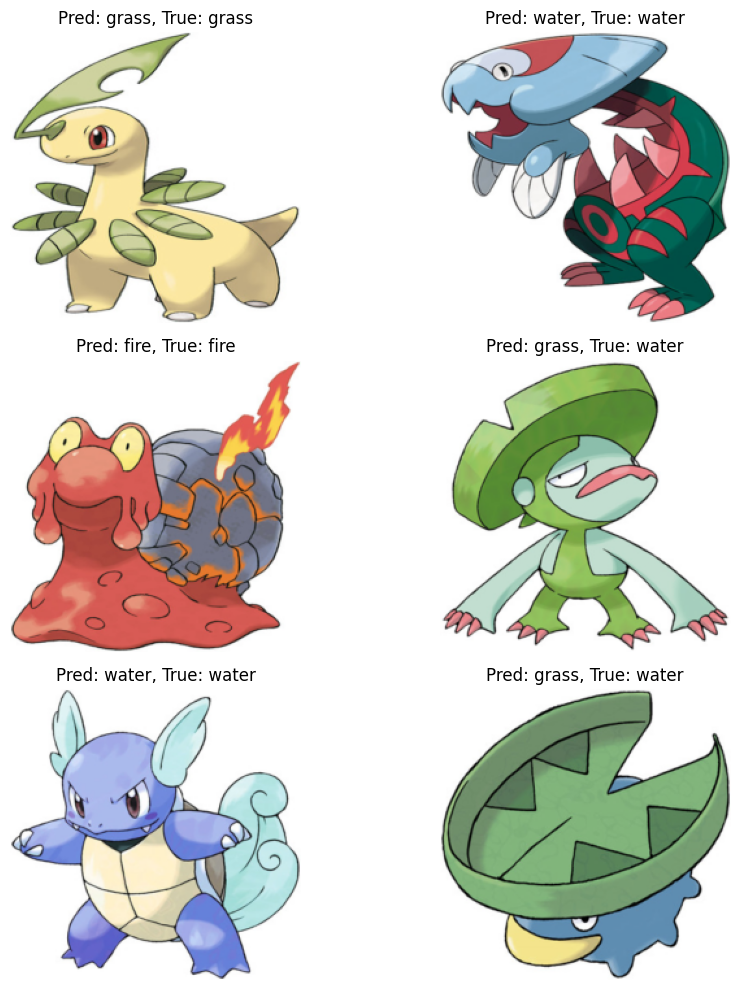

In [ ]:
visualize_random_samples(final_model)